In [1]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
from PIL import Image
import pytesseract
import re
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

In [ ]:
# tesseract download link
# https://github.com/tesseract-ocr/tesseract/wiki/4.0-with-LSTM#400-alpha-for-windows

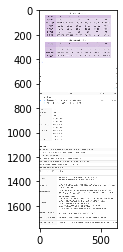

In [22]:
plt.imshow(cv2.imread('./crawling/img/split_size/screen_shot_73_1.jpg'))

In [21]:
%%time

# 사이즈차트를 뽑아올 대상 이미지 지정
image_file = os.path.join(file_path, img_list[-1])

# EAST detection에 사용될 설정값들을 args 변수에 넣음
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str,
                help="path to input image")
ap.add_argument("-east", "--east", type=str, 
                help="path to input EAST text detector")
ap.add_argument("-c", "--min-confidence", type=float, default=0.5, 
                help="minimum probability required to inspect a region")
# 참고: 넓이와 높이는 32의 배수여야 된다. 그래서 기본으로 320x320으로 지정한다.
ap.add_argument("-w", "--width", type=int, default=320, 
                help="nearest multiple of 32 for resized width")
ap.add_argument("-e", "--height", type=int, default=320, 
                help="nearest multiple of 32 for resized height")
ap.add_argument("-p", "--padding", type=float, default=0.0, 
                help="amount of padding to add to each border of ROI")


args = vars(ap.parse_known_args()[0])
args["image"] = image_file
args["east"] = 'frozen_east_text_detection.pb'

# 대상 이미지를 연다
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]

# 이미지 사이즈를 조정하고 조정된 비율을 변수에 담아논다
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)

image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# EAST 모델에서 갖고올 2 레이어를 지정한다:
# 1. 확률 레이더
# 2. 좌표 레이어
layerNames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

# 학습되어 있는 EAST 모델을 갖고온다
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

# BLOB 생성... blob이 뭔지는 정확히는 모르겠다
# 위에 링크를 따라가면 blob이 뭔지 설명이 있다
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# EAST 모델 예측 소요 시간
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# 확률 레이어로부터 행과 열을 갖고온다
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# 각 행마다 확률과 좌표를 대칭한다
for y in range(0, numRows):
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# 각 열에 있는 확률을 확인한다
	for x in range(0, numCols):
		# 확률이 낮으면 무시~
		if scoresData[x] < args["min_confidence"]:
			continue

		# 결과 특징맵은 4배 작다고 한다 - 4로 곱해준다
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# 결과값에 박스를 그리기 위한 대각 각도를 갖고온다
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# 좌표로 부터 높이와 넓이를 갖고온다
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# 대각선에 의한 좌표값들 추출 startX, startY ~ endX, endY
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# 박스좌표 추가, 확률 추가
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])


# non_max_suppression으로 겹치는 박스들을 정리한다
boxes = non_max_suppression(np.array(rects), probs=confidences)

def sort_y(val):
    return val[1]

def sort_x(val):
    return val[0]

# EAST 모델에서 값이 나오지 않으면 없다고 말해주자~
if len(boxes) == 0:
    print("EAST GOT NOTHING!!")

# 좋지는 않지만 일단 np.array를 리스트로 바꿔서 y값을 상대로 오름차순 정렬
boxes = boxes.tolist()
boxes.sort(key=sort_y)

reshaped_boxes = []
# 변수에 담아놨던 이미지 비율을 사용하여 EAST 결과 박스에 곱해준다
for (startX, startY, endX, endY) in boxes:
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	reshaped_boxes.append([startX, endX, startY, endY])
    
reshaped_boxes = np.array(reshaped_boxes)
print(reshaped_boxes)


# 여기서 부턴 곱지못한 코딩을 했으나 일단 돌아가니 양해부탁...

# 같은 y값(가로)에 있는 박스들을 묶어줘 region이란 변수에 담는다.
regions = {}
region = []
y_med = reshaped_boxes[0][2] + abs((reshaped_boxes[0][2] - reshaped_boxes[0][3])/2)
for hier in range(len(reshaped_boxes)):
    if reshaped_boxes[hier][2] < y_med and reshaped_boxes[hier][3] > y_med:
        region.append(reshaped_boxes[hier].tolist())
    else:
        regions[f'{hier}'] = region
        region = []
        y_med = reshaped_boxes[hier][2] + abs((reshaped_boxes[hier][2] - reshaped_boxes[hier][3])/2)
        region.append(reshaped_boxes[hier].tolist())
regions['last'] = region
print(regions)


# 여기서 부턴 tesseract 사용
# 추출된 region들을 확인해서 이미지에 뭔 문자들이 있는지 추출한다
# 사이즈차트 경우 기본적으로 S, M, L, XL 의 조합들이 있으니
# 사이즈차트 처럼(?)생긴 이미지만 저장한다고 생각하면 된다...
tick = 0
for group in regions:
    groot = regions.get(group)
    if len(groot) > 0:
        groot.sort(key=sort_x)
        gang = np.array(groot)
        true_region = [np.amin(gang, axis=0)[2], np.amax(gang, axis=0)[3], np.amin(gang, axis=0)[0], np.amax(gang, axis=0)[1]]
        print(true_region)
        
        text = pytesseract.image_to_string(orig[true_region[0]:true_region[1],0:orig.shape[1]])
        results = text.split()
        filtered = []
        for result in results:
            filtered.append(''.join(e for e in result if e.isalnum()).lower())
            
        print(filtered)
        
        size_check = []
        for x in filtered:
            if re.search("^s", x):
                if len(x) == 1:
                    size_check.append(x)
                elif x[-1].isnumeric():
                    size_check.append(x)
            elif re.search("^m", x):
                if len(x) == 1:
                    size_check.append(x)
                elif x[-1].isnumeric():
                    size_check.append(x)
            elif re.search("^l", x):
                if len(x) == 1:
                    size_check.append(x)
                elif x[-1].isnumeric():
                    size_check.append(x)
            elif re.search("^xl", x):
                if len(x) == 1:
                    size_check.append(x)
                elif x[-1].isnumeric():
                    size_check.append(x)
                
        if len(size_check) > 1:
            print('성공@@@@@@@@@@@@@@!@#(&*@(#ㅛ@*#&(*@&#(*&@#((*))))))')
            cv2.imwrite(f'./check_size_{tick}.png', orig[true_region[0]:true_region[1],0:orig.shape[1]])
            tick = tick + 1

# 	# draw the bounding box on the image
# 	cv2.rectangle(orig, (0, startY), (orig.shape[1], endY), (0, 255, 0), 2)

# cv2.imshow("Text Detection", orig)
# while(True):
# 	k = cv2.waitKey(33)
# 	if k == -1:  # if no key was pressed, -1 is returned
# 		continue
# 	else:
# 		break
# cv2.destroyAllWindows()

[INFO] loading EAST text detector...
[INFO] text detection took 0.303017 seconds
[[ 504  600  226  303]
 [ 348  488  606  672]
 [ 500  620  611  672]
 [ 464  600 1041 1108]
 [ 620  720 1041 1108]
 [ 716  820 1041 1108]
 [ 448  816 1356 1433]
 [ 444  712 1405 1466]]
{'1': [[504, 600, 226, 303]], '3': [[348, 488, 606, 672], [500, 620, 611, 672]], '6': [[464, 600, 1041, 1108], [620, 720, 1041, 1108], [716, 820, 1041, 1108]], '7': [[448, 816, 1356, 1433]], 'last': [[444, 712, 1405, 1466]]}
[226, 303, 504, 600]
['fos', 'xbr', 'xeu', 'lime', '2x7', '', 'daud', 'ale', 'atic', 'dol', '14', 'rleuc']
[606, 672, 348, 620]
['cbe', 'enbeut', '4', 'a', 'e', 'e', 'e', 'detail', 'point']
[1041, 1108, 464, 820]
['014257', '216']
[1356, 1433, 448, 816]
['2', 'ig', 'a22', 'ciee']
[1405, 1466, 444, 712]
['veacac', '', '140', '', '', 'ad', 'zie', 'a', '27hpfe', 'slelslo', 'mot', 'eet', 'sumitadin', 'esen']
Wall time: 3.51 s


In [30]:
image_file

'./crawling/images\\screen_shot_0_9.jpg'

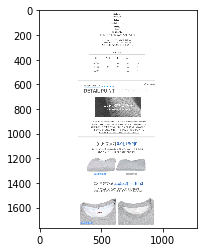

In [31]:
plt.imshow(cv2.imread(image_file))